In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.set_option('future.no_silent_downcasting', True)

In [5]:
path = "./comodity-price-prediction-penyisihan-arkavidia-9/Harga Bahan Pangan/"
path_train = np.sort(os.listdir(path + "train"))
path_test = np.sort(os.listdir(path + "test"))

In [6]:
path_train

array(['Bawang Merah.csv', 'Bawang Putih Bonggol.csv', 'Beras Medium.csv',
       'Beras Premium.csv', 'Cabai Merah Keriting.csv',
       'Cabai Rawit Merah.csv', 'Daging Ayam Ras.csv',
       'Daging Sapi Murni.csv', 'Gula Konsumsi.csv',
       'Minyak Goreng Curah.csv', 'Minyak Goreng Kemasan Sederhana.csv',
       'Telur Ayam Ras.csv', 'Tepung Terigu (Curah).csv'], dtype='<U35')

In [7]:
path_train[0]

'Bawang Merah.csv'

In [8]:
df_train = [pd.read_csv(path + "train/" + data) for data in path_train]

for i, df_pangan in enumerate(df_train):
    df_pangan["Pangan"] = path_train[i].replace(".csv", "")

df_train = pd.concat(df_train, axis=0, ignore_index=True)
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_train = df_train.set_index("Date")

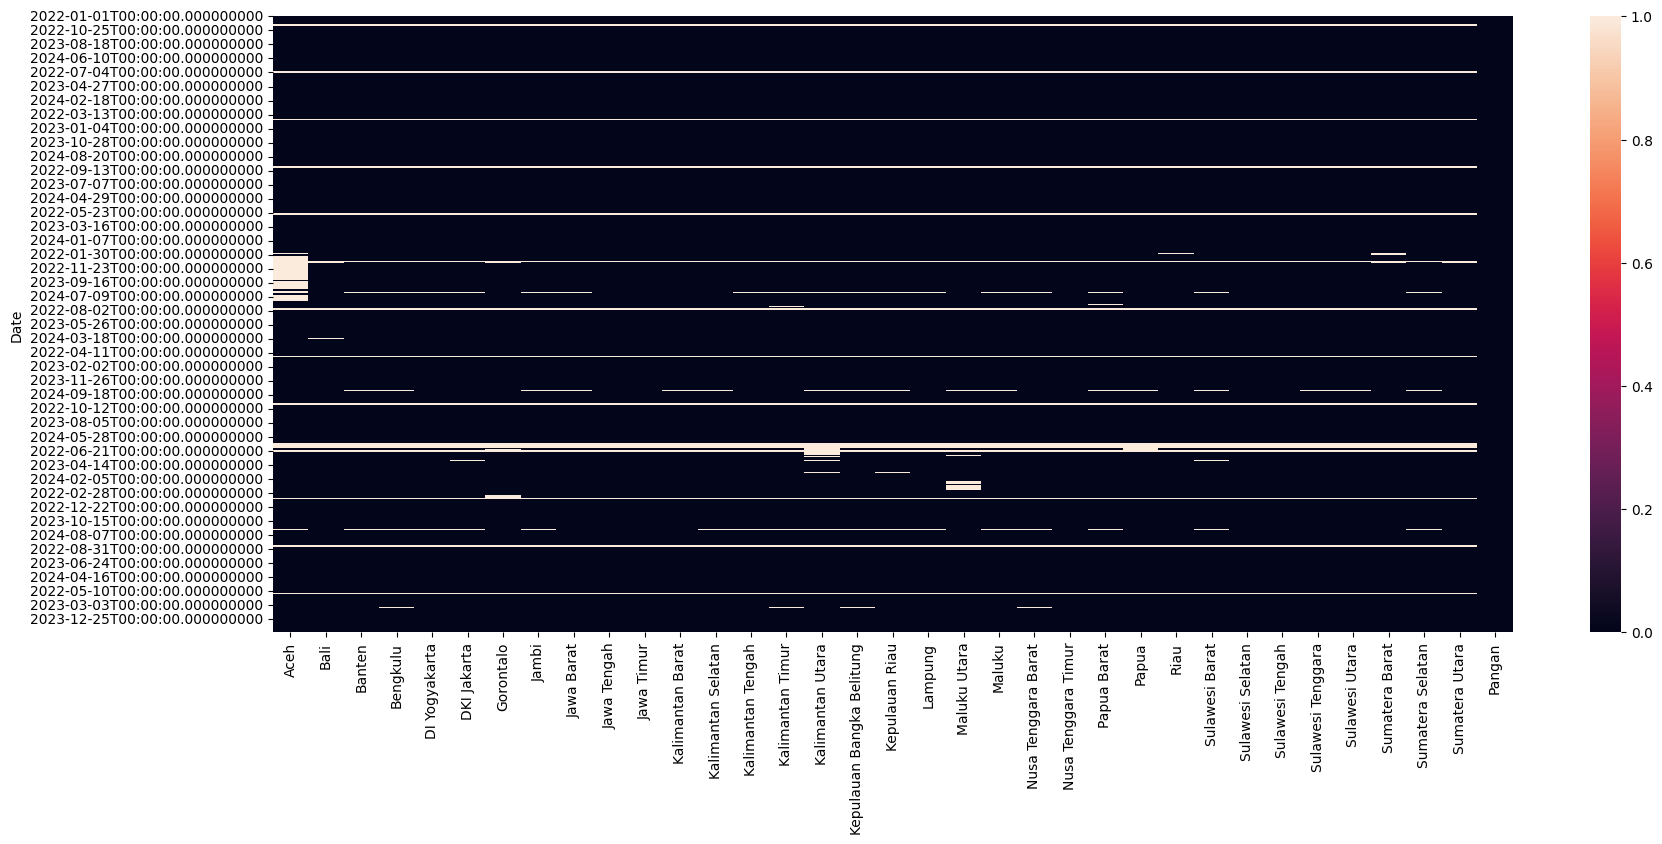

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(df_train.isna(), ax=ax);

In [10]:
list_provinsi = df_train.columns[:-1].to_list()

<Axes: xlabel='Date'>

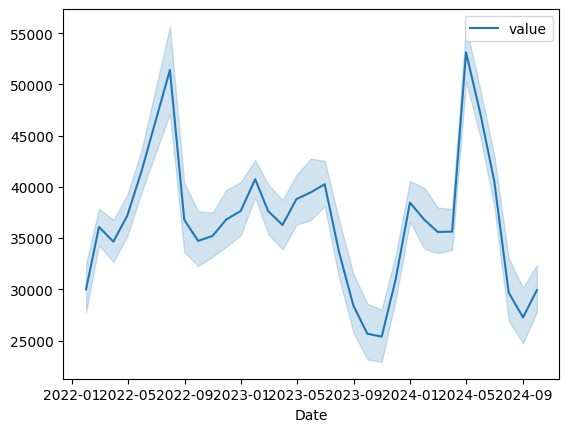

In [11]:
bawang_merah = df_train.loc[df_train["Pangan"] == "Bawang Merah", list_provinsi].asfreq("ME").T.melt().set_index("Date")
sns.lineplot(bawang_merah)

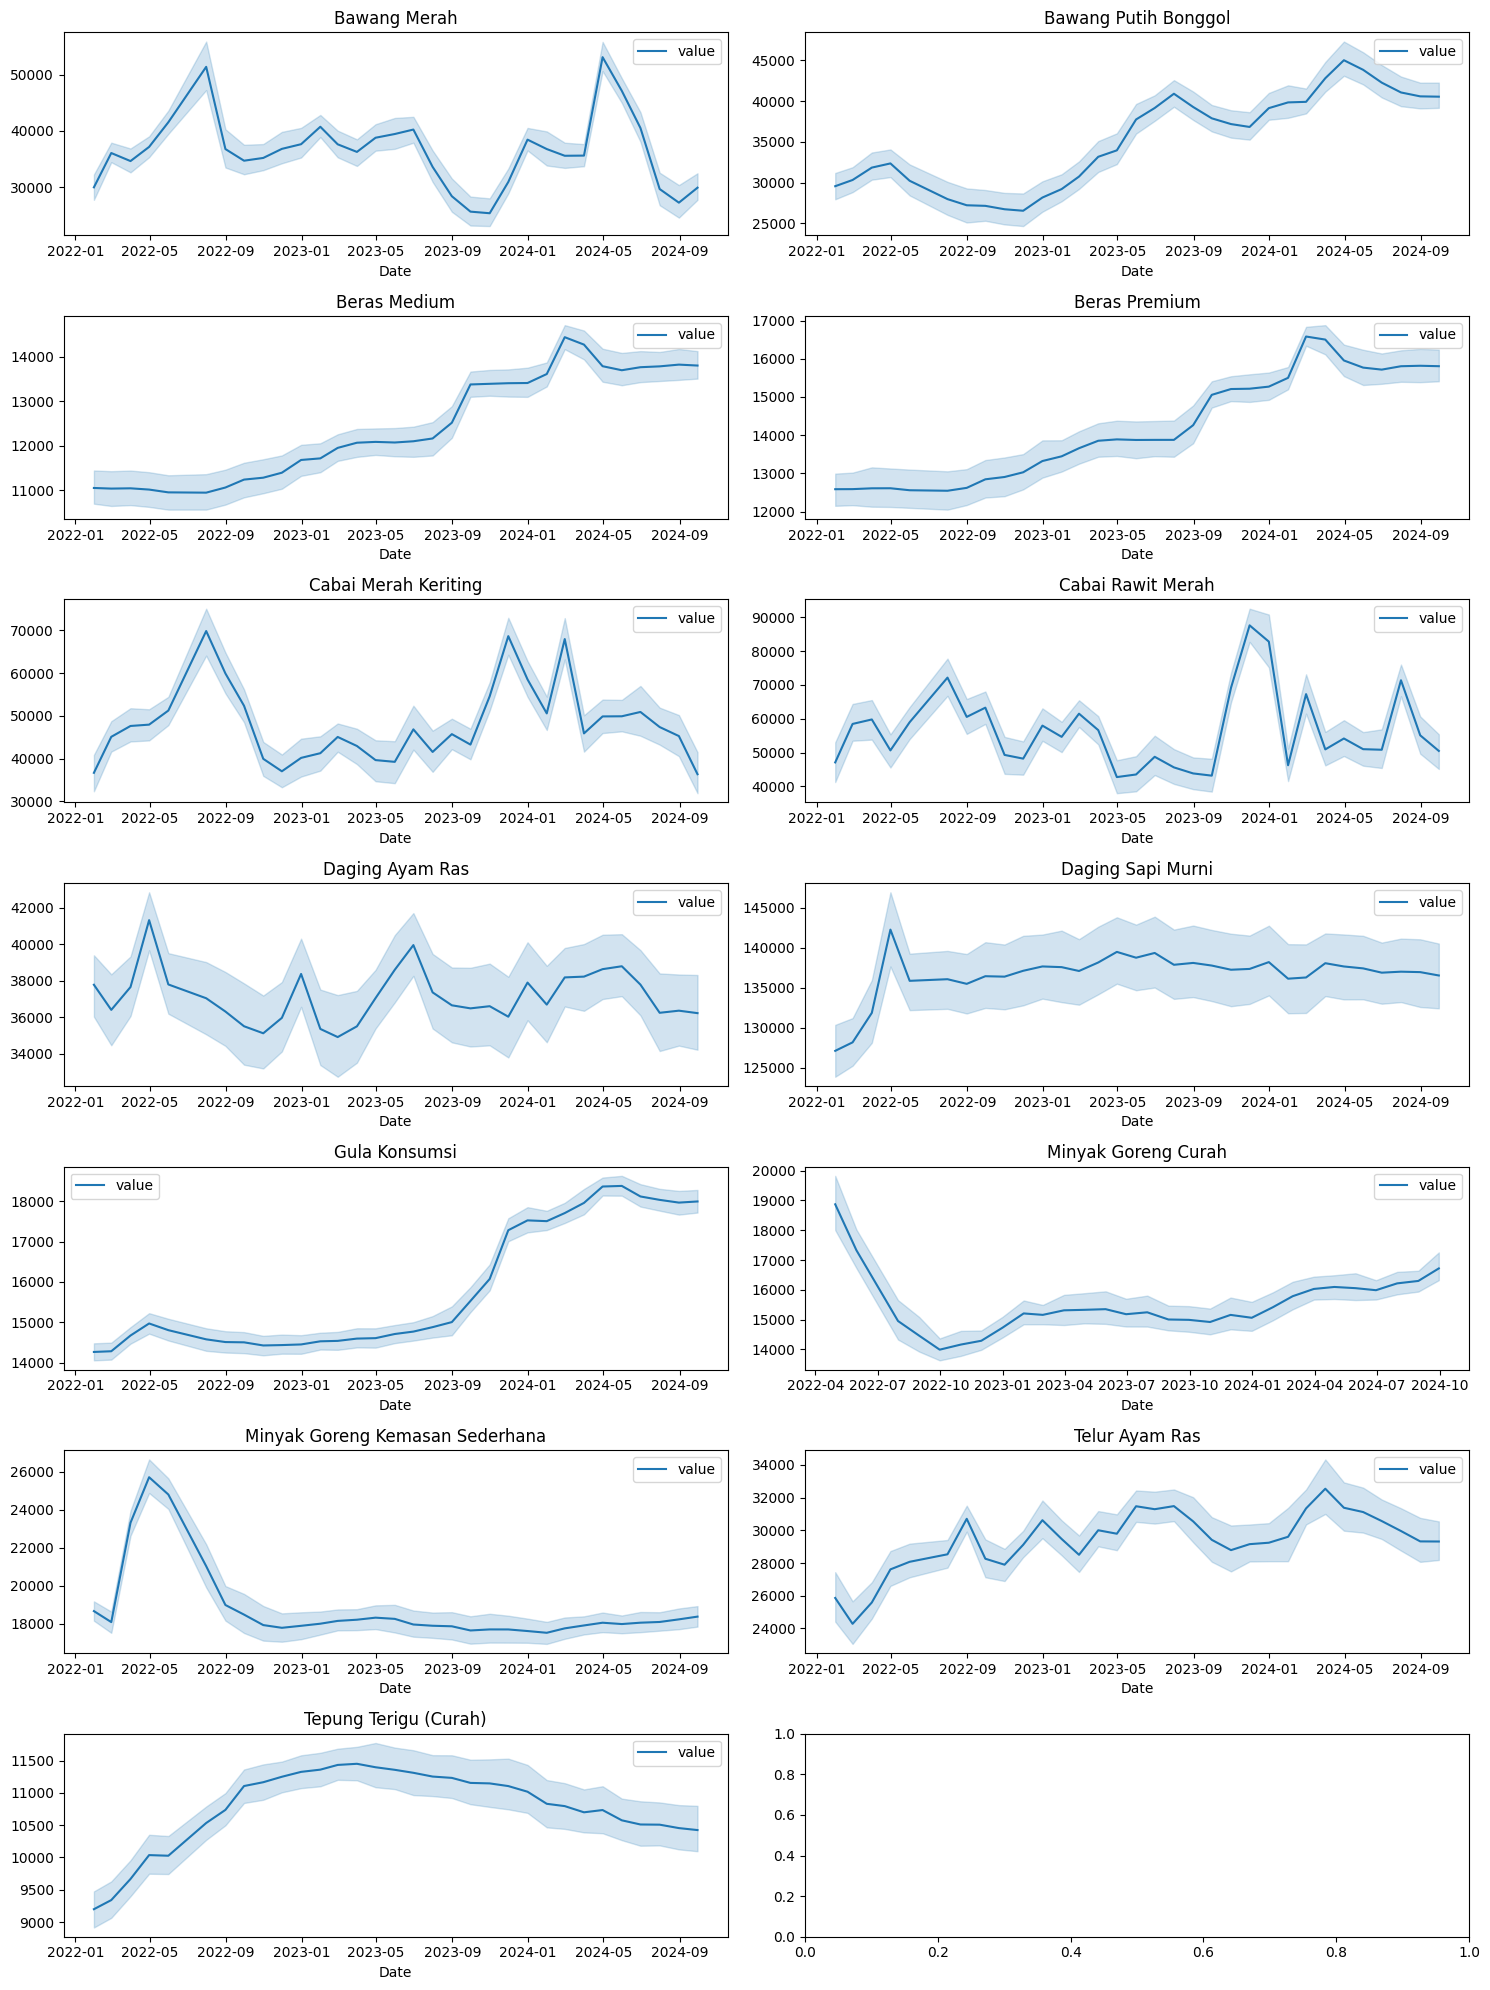

In [12]:
bahan_pangan = df_train["Pangan"].unique()

fig, ax = plt.subplots(int(len(bahan_pangan)/2) + 1, 2, figsize=(15, 20))
ax = ax.flatten()

for i, pangan in enumerate(bahan_pangan):
    groupby_pangan = df_train.loc[df_train["Pangan"] == pangan, list_provinsi].asfreq("ME").T.melt().set_index("Date")
    sns.lineplot(groupby_pangan, ax=ax[i])
    ax[i].title.set_text(pangan)
    
plt.tight_layout()

In [13]:
import xgboost as xgb
import copy
from sklearn.impute import KNNImputer

In [14]:
for pangan in bahan_pangan:
    pangan_df = df_train[df_train["Pangan"] == pangan]
    for prov in list_provinsi:
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].interpolate(method="time")
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].bfill()
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].ffill()
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].round(-1)
        

In [15]:

from sklearn.metrics import mean_absolute_percentage_error
import logging
from sklearn.preprocessing import MinMaxScaler

In [16]:
df_train = df_train.reset_index().rename(columns={"Date":"ds"})

In [17]:
path_commodity = "./comodity-price-prediction-penyisihan-arkavidia-9/Global Commodity Price/"
path_commodity_list = os.listdir(path_commodity)

commodity_df = [pd.read_csv(path_commodity + path)[["Date","Price"]].sort_values("Date") for path in path_commodity_list] 

for i, df_commodity in enumerate(commodity_df):
    df_commodity["Commodity"] = path_commodity_list[i].replace(".csv", "")

rename_commodity = {"Crude Oil WTI Futures Historical Data" : 1, 
                    "Natural Gas Futures Historical Data" : 2, 
                    "Newcastle Coal Futures Historical Data" : 3, 
                    "Palm Oil Futures Historical Data" : 4, 
                    "US Sugar 11 Futures Historical Data" : 5, 
                    "US Wheat Futures Historical Data" : 6}

commodity_df = pd.concat(commodity_df, axis=0, ignore_index=True)
commodity_df = commodity_df.rename(columns={"Date":"ds"})

commodity_df["ds"] = pd.to_datetime(commodity_df["ds"])
commodity_df["Commodity"] = commodity_df["Commodity"].replace(rename_commodity)
commodity_df["Price"] = commodity_df["Price"].apply(lambda x : str(x).replace(",", "")).astype(np.float64)

In [18]:
for i in range(1, 7):
    commodity = commodity_df[commodity_df["Commodity"] == i][["ds", "Price"]].rename(columns={"Price" : f"Com{i}"}).reset_index(drop=True)
    commodity_df = pd.merge(commodity_df, commodity, on="ds", sort=True)
    
commodity_df = commodity_df.drop(columns=["Price", "Commodity"])
commodity_df = commodity_df.drop_duplicates().reset_index(drop=True)

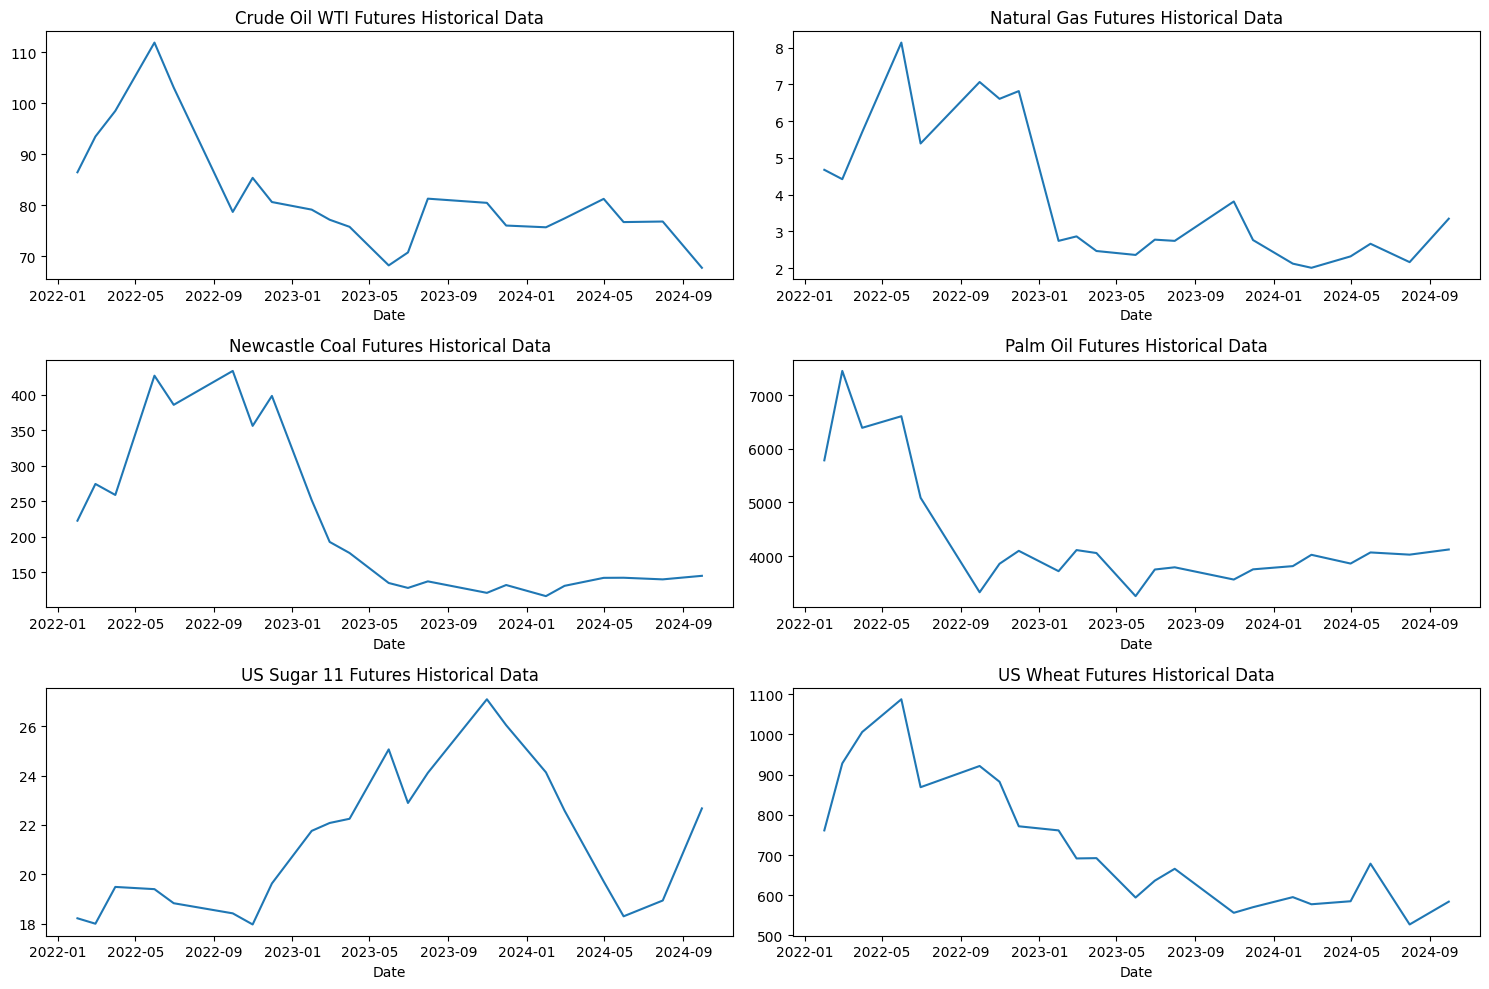

In [19]:
plt.figure(figsize=(15, 10))

for i in range(1, 7):
    plt.subplot(3, 2, i)
    sns.lineplot(commodity_df.set_index("ds").asfreq("ME"),x="ds", y=f"Com{i}")
    plt.xlabel("Date")
    plt.ylabel("")
    plt.title(f"{list(rename_commodity.keys())[i - 1]}")
    
plt.tight_layout()

In [20]:
path_exchange = "./comodity-price-prediction-penyisihan-arkavidia-9/Mata Uang/"
path_exchange_list = os.listdir(path_exchange)

exchange_list = {"MYRUSD=X" : "MYR", "SGDUSD=X" : "SGD", "THUSD=X" : "THB", "USDIDR=X" : "IDR"}

exchange_df = [pd.read_csv(path_exchange + path)[["Date","Adj Close"]].sort_values("Date") for path in path_exchange_list]

for i, df_exchange in enumerate(exchange_df):
    exchange_name = path_exchange_list[i].replace(".csv", "")
    exchange_df[i] = df_exchange.rename(columns={"Adj Close" : exchange_name})
    if i > 0:
        exchange_df[i] = exchange_df[i].drop(columns=["Date"])
    
df_exchange = pd.concat(exchange_df, axis=1)
df_exchange = df_exchange.rename(columns=exchange_list)
df_exchange = df_exchange.rename(columns={"Date":"ds"})
df_exchange["ds"] = pd.to_datetime(df_exchange["ds"])
df_exchange

,ds,MYR,THBUSD=X,IDR,SGD
0,2022-01-03,0.239521,0.030201,14215.000000,0.741730
1,2022-01-04,0.239808,0.030082,14283.599609,0.739033
2,2022-01-05,0.239006,0.030083,14385.500000,0.737621
3,2022-01-06,0.238550,0.030077,14446.500000,0.736534
4,2022-01-07,0.237473,0.029804,14408.000000,0.734786
...,...,...,...,...,...
711,2024-09-24,0.238067,0.030377,15174.099609,0.774647
712,2024-09-25,0.240964,0.030710,15121.099609,0.779812
713,2024-09-26,0.242219,0.030516,15201.500000,0.775326
714,2024-09-27,0.241546,0.030897,15070.000000,0.778889


### NHITS Model

In [21]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx, NHITS
from neuralforecast.losses.pytorch import MAPE, DistributionLoss

In [ ]:
ypred_list = []
id_list = []
for bahan in bahan_pangan:
    print("=" * 5,bahan, "=" * 5)
    for prov in list_provinsi:
        print(prov)
        df_prov_train = df_train[df_train["Pangan"] == bahan][["ds", prov]]
        df_prov_train = df_prov_train.rename(columns={prov:"y"})
        
        val_size = int(len(df_prov_train) * 0.15)
        corr_tolerance = 0.3
        
        df_prov_train = pd.merge(df_prov_train, commodity_df, on="ds", how="left")
        df_prov_train = pd.merge(df_prov_train, df_exchange, on="ds", how="left")
        
        corr_features = df_prov_train.corr()["y"][2:]
        corr_features = corr_features[np.abs(corr_features) > corr_tolerance].index.to_list()
        corr_features.insert(0, "ds")
        corr_features.insert(1, "y")
        
        df_prov_train = df_prov_train[corr_features]
        df_prov_train = df_prov_train.set_index("ds")
        
        df_prov_train = df_prov_train.interpolate(method="time")
        df_prov_train = df_prov_train.bfill()
        df_prov_train = df_prov_train.ffill()
        df_prov_train = df_prov_train.reset_index()
        
        for ex in corr_features[2:]:     
            scaler = MinMaxScaler()
            df_prov_train[ex] = scaler.fit_transform(df_prov_train[[ex]])
    
        df_futures = pd.read_csv(path + f"test/Gula Konsumsi.csv").rename(columns={"Date":"ds"})[["ds"]]
        df_futures = pd.to_datetime(df_futures["ds"])
        df_futures = df_futures.reset_index().rename(columns={"index":"unique_id"})
        df_futures["unique_id"] = 1
            
        df_prov_train = df_prov_train.reset_index().rename(columns={"index":"unique_id"})
        df_prov_train["unique_id"] = 1
        
        model_nhits = NHITS(len(df_futures), input_size=val_size + 12,
                        max_steps=25,
                        val_check_steps = 5,
                        hist_exog_list = corr_features[2:],
                        valid_loss=MAPE(),
                        loss=MAPE(),
                        batch_size=128,
                        n_freq_downsample=[2, 1, 1],
                        accelerator="cpu")
    
        forecast = NeuralForecast(
            models=[model_nhits],
            freq="D"
        )

        
        forecast.fit(df_prov_train, val_size=val_size, verbose=False)
        ypred = forecast.predict(futr_df=df_futures, verbose=False)
        
        id_name = df_futures["ds"].apply(lambda x : f"{bahan}/{prov}/{str(x)}")
        id_list.append(np.array(id_name))
        
        ypred_list.append(np.array(ypred))


In [ ]:
np_id_list = np.array(id_list).reshape(-1,)
np_pred_list = np.array(ypred_list)[:, :, 2].reshape(-1,)

df_pred = pd.DataFrame(data={"id":np_id_list, "price":np_pred_list})
df_pred["id"] = df_pred["id"].replace({" 00:00:00" : ""}, regex=True)
df_pred.to_csv("submissionWithNHITS.csv", index=False)